---
title       : "Introduction to Neural Networks" 
subtitle    : "Single Layer Perceptrons"
author      : Paul Schrimpf
date        : `j using Dates; print(Dates.today())`
bibliography: "../ml.bib"
---

[![](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/)

This work is licensed under a [Creative Commons Attribution-ShareAlike
4.0 International
License](http://creativecommons.org/licenses/by-sa/4.0/) 


### About this document 

This document was created using Weave.jl. The code is available in
[on github](https://github.com/schrimpf/NeuralNetworkEconomics.jl). The same
document generates both static webpages and associated [jupyter
notebook](slp.ipynb). 

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

In [1]:
markdown = try
  "md" in keys(WEAVE_ARGS) && WEAVE_ARGS["md"]
catch
  false
end

if !("DISPLAY" ∈ keys(ENV))
  # Make gr and pyplot backends for Plots work without a DISPLAY
  ENV["GKSwstype"]="nul"
  ENV["MPLBACKEND"]="Agg"
end
# Make gr backend work with λ and other unicode
ENV["GKS_ENCODING"] = "utf-8"

using NeuralNetworkEconomics
docdir = joinpath(dirname(Base.pathof(NeuralNetworkEconomics)), "..","docs")

using Pkg
Pkg.activate(docdir)
Pkg.instantiate()

Activating environment at `~/.julia/dev/NeuralNetworkEconomics/docs/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


# Introduction

Neural networks, especially deep neural networks, have come to
dominate some areas of machine learning. Neural networks are
especially prominent in natural language processing, image
classification, and reinforcement learning. This documents gives a
brief introduction to neural networks. 

Examples in this document will use
[`Flux.jl`](https://fluxml.ai/Flux.jl/stable/). 
An alternative Julia package for deep learning is
[`Knet.jl`](https://denizyuret.github.io/Knet.jl/latest/). There is a
good discussion comparing Flux and Knet [on
discourse.](https://discourse.julialang.org/t/state-of-deep-learning-in-julia/28049). 
We will not have Knet examples here, but the documentation for Knet is
excellent and worth reading even if you plan to use Flux.

## Additional Reading

- @goodfellow2016 [*Deep Learning*](http://www.deeplearningbook.org)
- [`Knet.jl`
  documentation](https://denizyuret.github.io/Knet.jl/latest/)
  especially the textbook
- @klok2019 *Statistics with Julia:Fundamentals for Data Science,
  MachineLearning and Artificial Intelligence*
    
  
# Single Layer Neural Networks

We will describe neural networks from a perspective of nonparametric
estimation. Suppose we have a target function, $f: \R^p \to \R$. In
many applications the target function will be a conditional
expectation, $f(x) = \Er[y|x]$. 

A single layer neural network approximates $f$ as follows
$$
\hat{f}(x) = \sum_{j=1}^r \beta_j 
\psi(w_j'x + b_j)
$$
Here $r$ is the width of the layer. $\beta_j$ are scalars. 
$\psi:\R \to \R$ is a nonlinear activation function. Common activation
functions include:

- Sigmoid $\psi(t) = 1/(1+e^{-t})$

- Tanh $\psi(t) = \frac{e^t -e^{-t}}{e^t + e^{-t}}$

- Rectified linear $\psi(t) = t 1(t\geq 0)$

The $w_j \in \R^p$ are called weights and $b_j \in \R$ are biases. 

You may have heard about the universal approximation theorem. This
refers to the fact that as $r$ increases, a neural network can
approximate any function. Mathematically, for some large 
class of functions $\mathcal{F}$, 

$$
\sup_{f \in \mathcal{F}} \lim_{r \to \infty} \inf_{\beta, w, b} \Vert
f(x) - \sum_{j=1}^r \beta_j \psi(w_j'x+b_j) \Vert = 0
$$

@hornik1989 contains one of the earliest results along these
lines. Some introductory texts mention the universal approximation
theorem as though it is something special for neural networks. This is
incorrect. In particular, the universal approximation theorem does not
explain why neural networks seem to be unusually good at
prediction. Most nonparametric estimation methods (kernel, series,
forests, etc) satisfy a similar conditions. 

# Training 

Models in `Flux.jl` all involve a differentiable loss function. The
loss function is minimized by a variant of gradient descent. Gradients
are usually calculated using reverse automatic differentiation
(backpropagation is a variant of reverse automatic differentiation
specialized for the structue of neural networks). A low level way to
use `Flux.jl` is to write your loss function as a typical Julia
function, as in the following code block.

In [2]:
using Plots, Flux, Statistics
# some function to estimate
f(x) = sin(x^x)/2^((x^x-π/2)/π)
function simulate(n,σ=1)
  x = rand(n,1).*π
  y = f.(x) .+ randn(n).*σ
  (x,y)
end

"""
   slp(r, activation=(t)-> 1 ./ (1 .+ exp.(.-t)), dimx=1 )

Construct a single layer perception with width `r`. 
"""
function slp(r, activation=(t)-> 1 ./ (1 .+ exp.(.-t)), dimx=1)
  # Parameters to be minimized wrt have to be declared for tracking
  # for reverse mode autodiff.
  w = param(randn(dimx,r))
  b = param(randn(1,r))
  β = param(randn(r))
  θ = Tracker.Params([β, w, b])
  pred(x) = activation(x*w.+b)*β
  loss(x,y) = mean((y.-pred(x)).^2)
  return(θ=θ, predict=pred,loss=loss)
end
x, y = simulate(1000, 0.5)
xg = 0:0.01:π
rs = [2, 3, 5, 7, 9]

5-element Array{Int64,1}:
 2
 3
 5
 7
 9

1000 iteration, loss=0.324934429062252
2000 iteration, loss=0.2842598501820037
3000 iteration, loss=0.2659268947854742
4000 iteration, loss=0.2571163721687483
5000 iteration, loss=0.2531530298814595
1000 iteration, loss=0.3186756945688004
2000 iteration, loss=0.288915980372469
3000 iteration, loss=0.26111430240336825
4000 iteration, loss=0.25764093921899694
5000 iteration, loss=0.25552604533013185
1000 iteration, loss=0.3225723833870158
2000 iteration, loss=0.2802507314589622
3000 iteration, loss=0.27140169569582856
4000 iteration, loss=0.266848076941608
5000 iteration, loss=0.26361809043618956
1000 iteration, loss=0.3324559733543022
2000 iteration, loss=0.29634921749790977
3000 iteration, loss=0.2740599939312151
4000 iteration, loss=0.26750705342310543
5000 iteration, loss=0.2644464982470199
1000 iteration, loss=0.3069531262937542
2000 iteration, loss=0.2987222255952218
3000 iteration, loss=0.29340555016445646
4000 iteration, loss=0.28950099456826434
5000 iteration, loss=0.28579876909

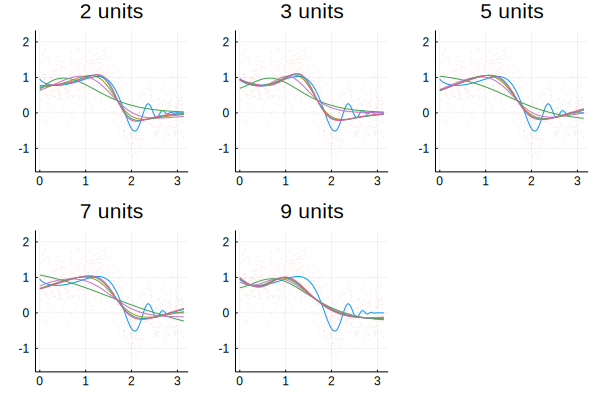

In [3]:
figs = Array{typeof(plot(0)),1}(undef,length(rs))
for r in eachindex(rs)
  m = slp(rs[r])
  figs[r]=plot(xg, f.(xg), lab="True f", title="$(rs[r]) units")
  figs[r]=scatter!(x,y, markeralpha=0.1, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 5000
  for i = 1:maxiter
    Flux.train!(m.loss, m.θ, [(x, y)], Flux.AMSGrad())
    if (i % (maxiter ÷ 5))==0
      l=Tracker.data(m.loss(x,y))
      println("$i iteration, loss=$l")
      figs[r]=plot!(xg,Tracker.data(m.predict(xg)), lab="") #, lab="$i iterations, loss=$l")
    end
  end
end
plot(figs..., legend=false)

Notice how even though a wider network can approximate $f$ better,
wider networks also take more training iterations to minimize the
loss. This is typical of any minimization algorithm --- the number of
iterations increases with the problem size. 

Each invocation of `Flux.train!` completes one iteration of gradient
descent. As you might guess from this API, it is common to train
neural networks for a fixed number of iterations instead of until
convergence to a local minimum. The number of training iterations can
act as a regularization parameter. 

`Flux.jl` also contains some higher level functions for creating loss
functions for neural networks. Here is the same network as in the
previous code block, but using the higher level API.

1000 iteration, loss=0.3289668195583084
2000 iteration, loss=0.28517430763057855
3000 iteration, loss=0.26591422641318907
4000 iteration, loss=0.26124342385931226
5000 iteration, loss=0.25819801657485
1000 iteration, loss=0.3127906877316625
2000 iteration, loss=0.28789984728461565
3000 iteration, loss=0.27330960271747656
4000 iteration, loss=0.2639457505797568
5000 iteration, loss=0.25975720784394934
1000 iteration, loss=0.31083496589174364
2000 iteration, loss=0.2853319078963296
3000 iteration, loss=0.2625102026131425
4000 iteration, loss=0.2578580892963785
5000 iteration, loss=0.2560214759915117
1000 iteration, loss=0.3203329634213688
2000 iteration, loss=0.30439754452731127
3000 iteration, loss=0.29269440843197464
4000 iteration, loss=0.2846800318291312
5000 iteration, loss=0.27719581942561894
1000 iteration, loss=0.31911277615535233
2000 iteration, loss=0.3045612858078042
3000 iteration, loss=0.2907740852771957
4000 iteration, loss=0.2806356922077187
5000 iteration, loss=0.27156395

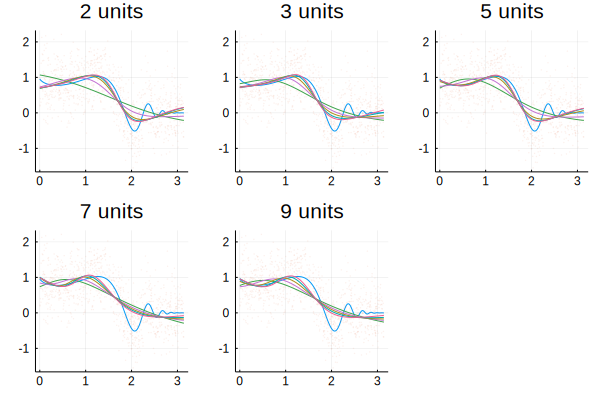

In [4]:
dimx = 1
figs = Array{typeof(plot(0)),1}(undef,length(rs))
for r in eachindex(rs)
  m = Chain(Dense(dimx, rs[r], Flux.σ), Dense(rs[r], 1))
  figs[r]=plot(xg, f.(xg), lab="True f", title="$(rs[r]) units")
  figs[r]=scatter!(x,y, alpha=0.1, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 5000
  for i = 1:maxiter
    Flux.train!((x,y)->Flux.mse(m(x'),y'), Flux.params(m), [(x, y)], Flux.AMSGrad() ) #,
                #cb = Flux.throttle(()->@show(Flux.mse(m(x'),y')),100))
    if (i % (maxiter ÷ 5))==0
      l=Tracker.data(Flux.mse(m(x'), y'))
      println("$i iteration, loss=$l")
      figs[r]=plot!(xg,Tracker.data(m(xg'))', lab="")#, lab="$i iterations, loss=$l")
    end
  end
end
plot(figs..., legend=false) #, title="Sigmoid")

The figures may not appear identical to the first example since the
initial values differ. 

Large applications of neural networks often use rectified linear
activation for efficiency. Let's see how the same example behaves with
(leaky) rectified linear activation.

1000 iteration, loss=0.32829985609204504
2000 iteration, loss=0.32829794073956553
3000 iteration, loss=0.32829752362865927
4000 iteration, loss=0.32829740416017356
5000 iteration, loss=0.3282973201081707
1000 iteration, loss=0.32828230895157756
2000 iteration, loss=0.3282804338282635
3000 iteration, loss=0.3282783251667889
4000 iteration, loss=0.3282767647663141
5000 iteration, loss=0.32827522421034994
1000 iteration, loss=0.30995196632237915
2000 iteration, loss=0.30753612259435337
3000 iteration, loss=0.30577271960400826
4000 iteration, loss=0.30437369259310804
5000 iteration, loss=0.303236138804437
1000 iteration, loss=0.3150318628441144
2000 iteration, loss=0.3106368008046222
3000 iteration, loss=0.30765666798770186
4000 iteration, loss=0.30622982276608135
5000 iteration, loss=0.30529008560518556
1000 iteration, loss=0.33315769498663156
2000 iteration, loss=0.3324139357953585
3000 iteration, loss=0.3318717885494199
4000 iteration, loss=0.3311559758350849
5000 iteration, loss=0.3304

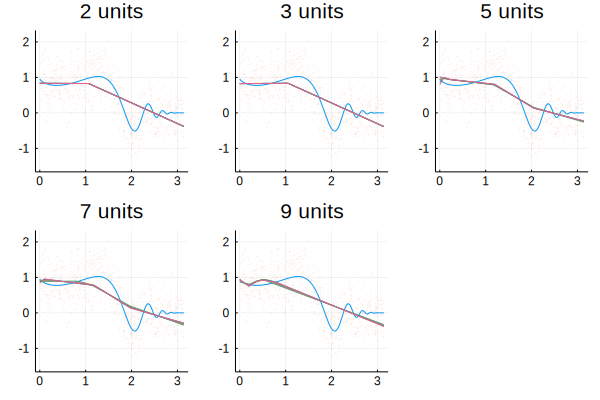

In [5]:
dimx = 1
figs = Array{typeof(plot(0)),1}(undef,length(rs))
for r in eachindex(rs)
  m = Chain(Dense(dimx, rs[r], Flux.leakyrelu), Dense(rs[r], 1)) # notice the change 
  figs[r]=plot(xg, f.(xg), lab="True f", title="$(rs[r]) units")
  figs[r]=scatter!(x,y, alpha=0.1, markersize=1, markerstrokewidth=0, lab="")
  maxiter = 5000
  for i = 1:maxiter
    Flux.train!((x,y)->Flux.mse(m(x'),y'), Flux.params(m), [(x, y)], Flux.AMSGrad()) #,
                #cb = Flux.throttle(()->@show(Flux.mse(m(x'),y')),100))
    if (i % (maxiter ÷ 5))==0
      l=Tracker.data(Flux.mse(m(x'), y'))
      println("$i iteration, loss=$l")
      figs[r]=plot!(xg,Tracker.data(m(xg'))', lab="")#, lab="$i iterations, loss=$l")
    end
  end
end
plot(figs..., legend=false) #, title="ReLu")

# Rate of convergence

- @chen1999
- $f(x) = \Er[y|x]$ with Fourier representation
$$ f(x) = \int e^{i a'x} d\sigma_f(a) $$
  where $\int (\sqrt{a'a} \vee 1) d|\sigma_f|(a) < \infty$
- Network sieve :
$$ \begin{align*}
\mathcal{G}_n = \{ &
g: g(x) = \sum_{j=1}^{r_n} \beta_j (a_j'a_j \vee 1)^{-1}
\psi(a_j'x + b_j), \\ & \norm{\beta}_1 \leq B_n \}
\end{align*}
$$

The setup in @chen1999 is more general. They consider estimating both
$f$ and its first $m$ derivatives. Here, we focus on the case of just
estimating $f$. @chen1999 also consider estimation of functions other
than conditional expectations.

The restriction on $f$ in the second bullet is used to control
approximation error. The second bullet says that $f$ is the inverse
Fourier transform of measure $\sigma_f$. The bite of the restriction
on $f$ comes from the requirement that $\sigma_f$ be absolutely
integral, $\int (\sqrt{a'a} \vee 1) d|\sigma_f|(a) < \infty$. It would
be a good exercise to check whether this restriction is satisfied by
some familiar types of functions. @barron1993 first showed that neural
networks approximate this class of functions well, and compares the
approximation rate of neural networks to other function approximation
results.

# References